# RNN 循环神经网络 (分类)

In [14]:
%matplotlib inline
import torch
from torch import nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 2           # 训练整批数据多少次, 为了节约时间, 我们只训练两次
BATCH_SIZE = 64
# 要读28次
TIME_STEP = 28      # rnn 时间步数 / 图片高度
# 每一步读入28个像素点
INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 Fasle

In [15]:
# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='data/mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


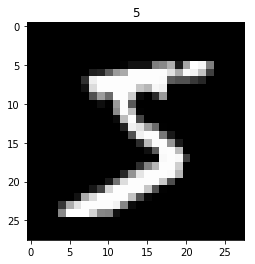

In [17]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [24]:
# Data Loader for easy mini-batch return in training
# 批训练 50 samples，1 channel，28x28 （50，1，28，28）
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(
    root='data/mnist/',
    train=False, 
    transform=transforms.ToTensor())
# 测试仅仅测试前2000个
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array

In [21]:
test_x.shape, test_y.shape

(torch.Size([2000, 28, 28]), (2000,))

# RNN模型

和以前一样, 我们用一个 class 来建立 RNN 模型. 这个 RNN 整体流程是

1.(input0, state0) -> LSTM -> (output0, state1);

2.(input1, state1) -> LSTM -> (output1, state2);

3.…

4.(inputN, stateN)-> LSTM -> (outputN, stateN+1);

5.outputN -> Linear -> prediction. 通过LSTM分析每一时刻的值, 并且将这一时刻和前面时刻的理解合并在一起, 生成当前时刻对前面数据的理解或记忆. 传递这种理解给下一时刻分析.

In [25]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(    # LSTM效果优于nn.RNN
            input_size = INPUT_SIZE, # 图片每行的数据像素点
            hidden_size = 64,       #  # rnn hidden unit
            num_layers=2,           # 有几层rnn layer
            # (time_step, batch, input) => (batch, time_step, input) 这里把batch_first作为第一个维度
            batch_first=True,       # input & output 会以batch_size作为第一维度的特征集 (batch, time_step, input_size)
        )
        self.out = nn.Linear(64, 10) #输出层：全链接层
    
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # x (batch, time_step, input_size)
        # (h_n, h_c):分线程的hidden_state, 主线程的hidden_state
        # None是代表初始状态首先是否有hidden_state
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        # 选取最后一个时刻的output
        out = self.out(r_out[:, -1, :])  # (batch, time_step, input)
        return out

In [26]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()

In [28]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 2.2884 | test accuracy: 0.09
Epoch:  0 | train loss: 1.0451 | test accuracy: 0.52
Epoch:  0 | train loss: 0.8946 | test accuracy: 0.69
Epoch:  0 | train loss: 0.4035 | test accuracy: 0.85
Epoch:  0 | train loss: 0.2924 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3040 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2142 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1226 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1522 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2459 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0714 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0851 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0384 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0490 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0538 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2599 | test accuracy: 0.96
Epoch:  0 | train loss: 0.3648 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1124 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1164 | test accuracy

In [30]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
print("test_output =",test_output)
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

test_output = tensor([[-2.4187, -0.7667, -0.0907,  0.8577,  1.3115, -1.5469, -6.7107,  9.4656,
         -3.4799,  1.7803],
        [-2.1161,  1.5862,  6.8687,  0.5203, -2.7447,  0.5099, -0.7749, -0.5346,
         -1.8792, -2.9276],
        [-2.7238,  9.9543, -0.7631, -0.9786, -2.4598, -0.2977,  0.4392, -1.1819,
          0.2710, -2.6756],
        [ 4.9974, -2.5262, -0.2144, -0.7637, -0.0394,  0.1713,  2.7421, -5.1624,
          0.1319, -1.3330],
        [-1.6527, -3.6279, -1.2491, -1.4865,  9.2054, -2.2675, -2.5976,  1.1462,
         -1.3693,  1.5403],
        [-3.0255,  9.8001, -1.5727, -0.2313, -2.6380, -0.3574, -1.1561, -0.6074,
          0.0815, -1.6385],
        [-2.6744, -0.5049, -2.0009, -3.1031,  8.4007, -4.3521, -2.5849,  2.4468,
          2.3970,  0.4577],
        [-3.1738, -2.5806, -1.9828, -1.4687,  1.1565,  1.0811, -2.3863, -1.0786,
         -1.2059,  7.0204],
        [-1.4658,  1.3413, -1.2240, -3.4047, -1.1586,  3.7519,  1.9423, -2.7997,
          3.7690, -0.1859],
     

# RNN 循环神经网络 (回归)

### 训练数据 

我们要用到的数据就是这样的一些数据, 我们想要用**sin**的曲线预测出**cos**的曲线.

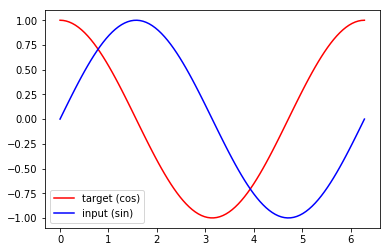

In [31]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)  # float32 for converting torch FloatTensor
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [33]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

        # instead, for simplicity, you can replace above codes by follows
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # outs = outs.view(-1, TIME_STEP, 1)
        # return outs, h_state
        
        # or even simpler, since nn.Linear can accept inputs of any dimension 
        # and returns outputs with same dimension except for the last
        # outs = self.out(r_out)
        # return outs

In [34]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [35]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [36]:
h_state = None      # for initial hidden state

In [37]:
plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

<Figure size 864x360 with 0 Axes>

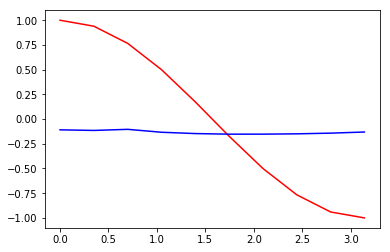

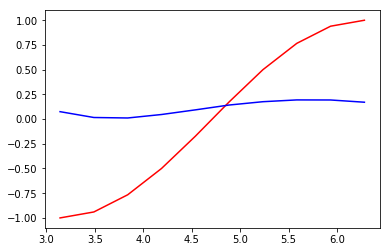

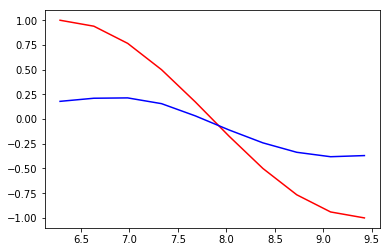

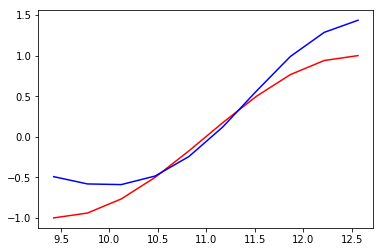

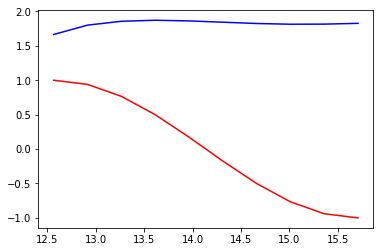

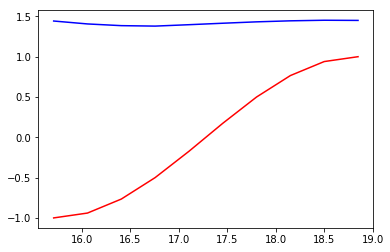

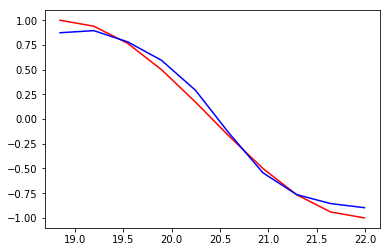

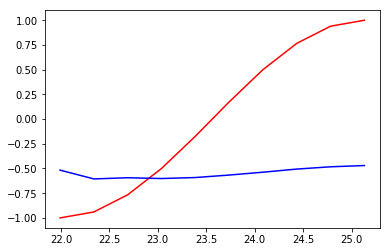

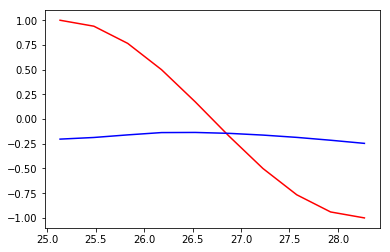

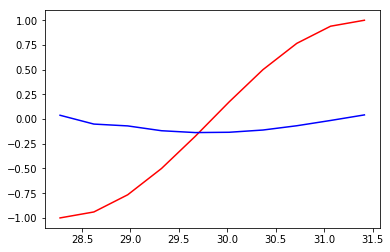

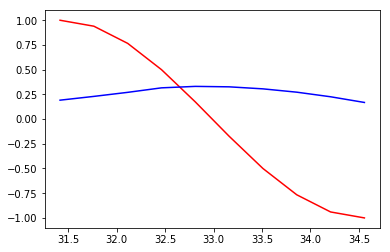

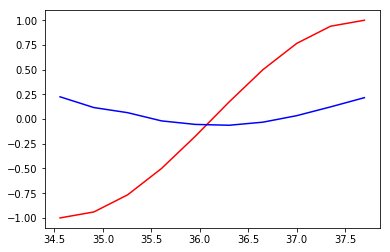

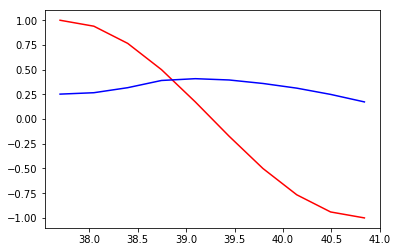

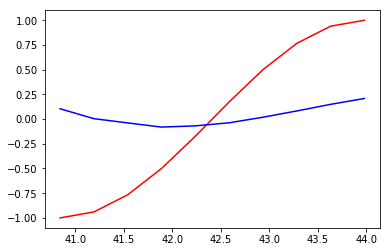

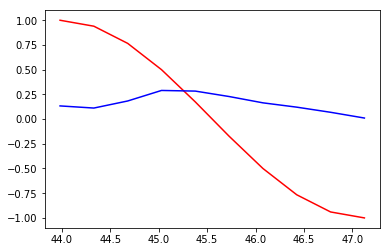

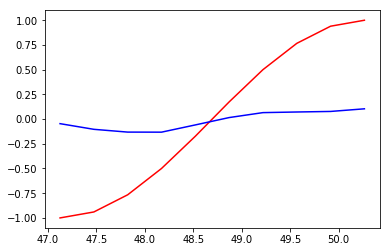

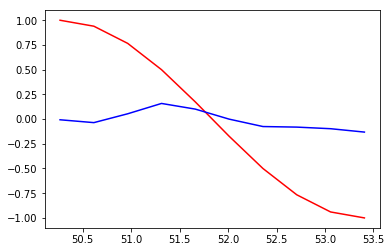

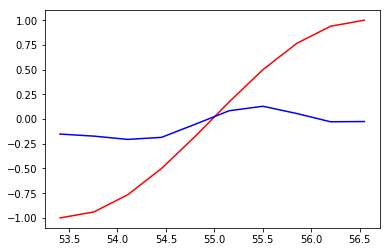

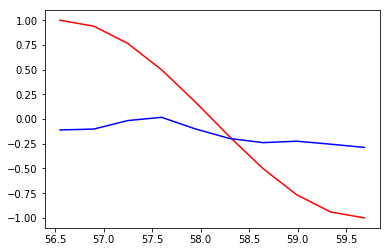

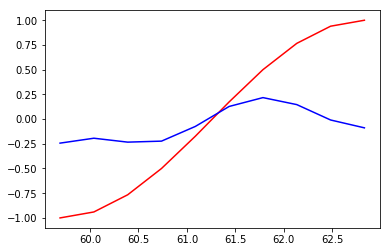

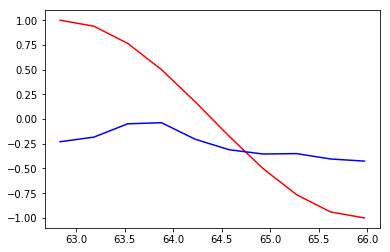

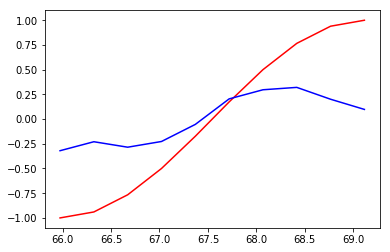

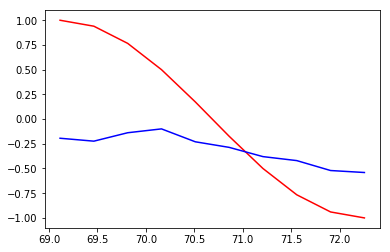

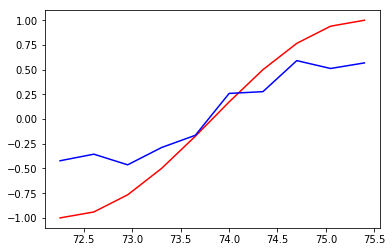

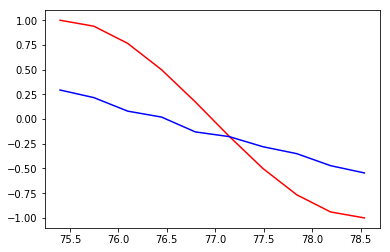

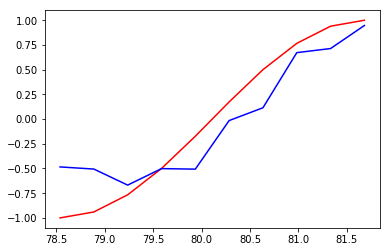

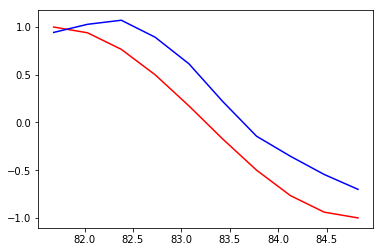

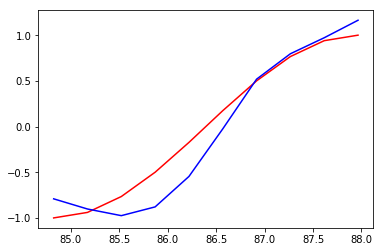

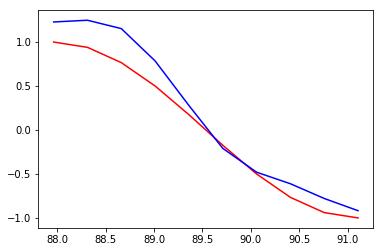

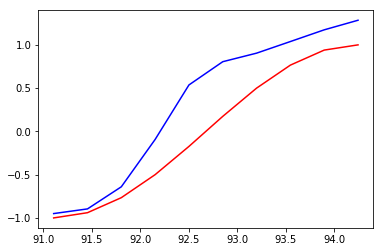

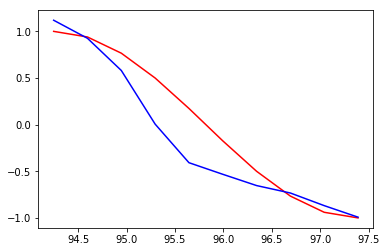

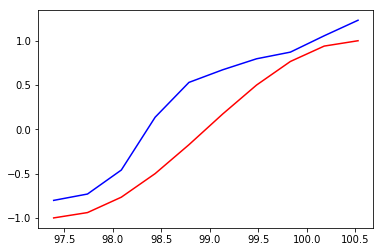

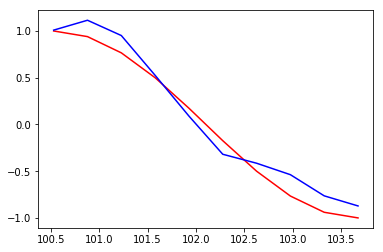

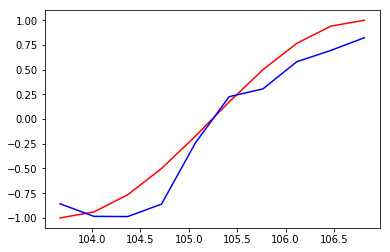

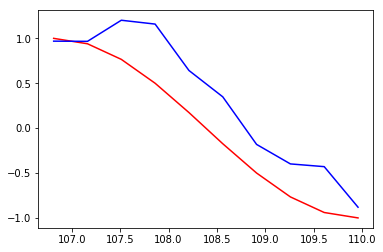

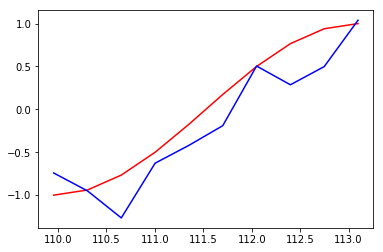

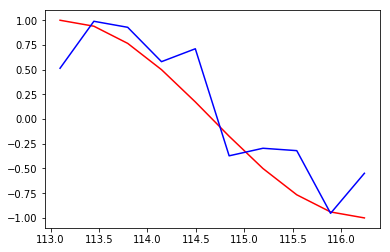

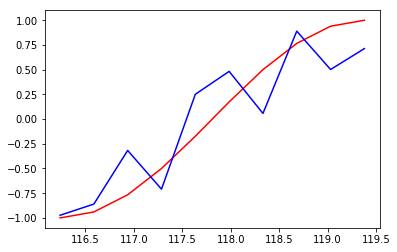

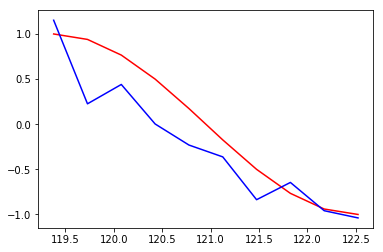

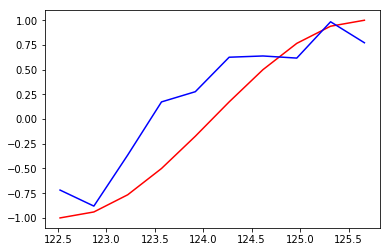

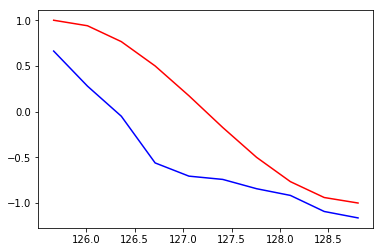

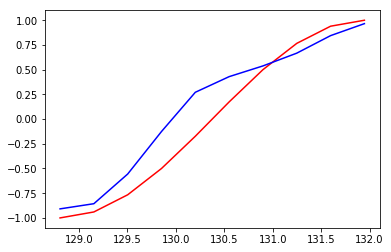

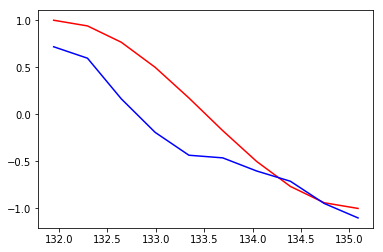

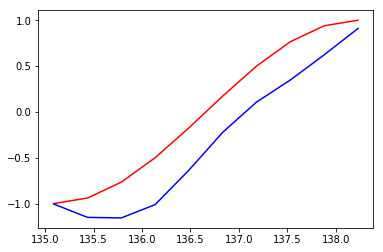

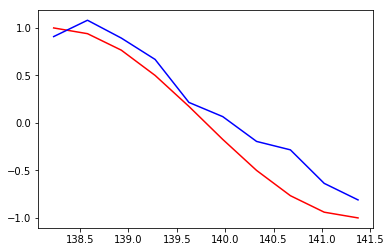

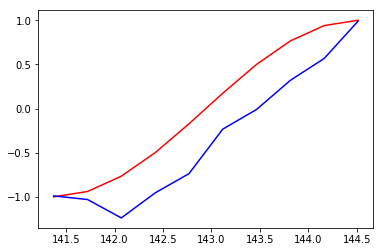

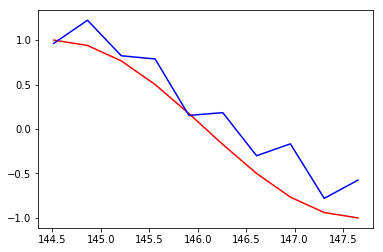

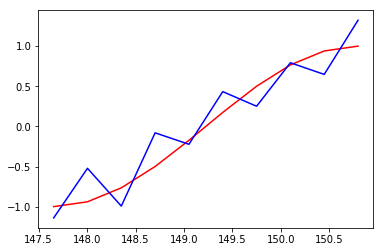

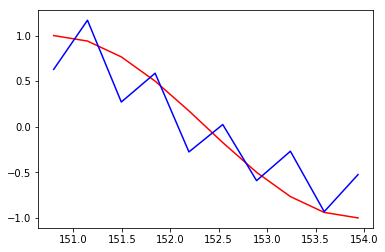

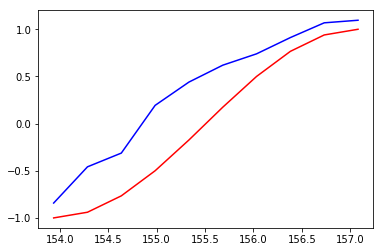

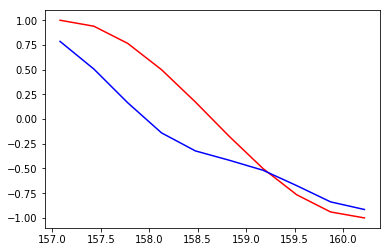

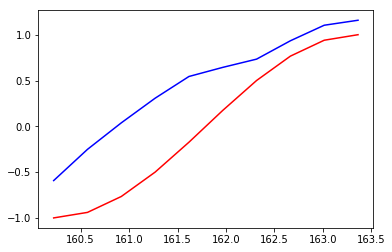

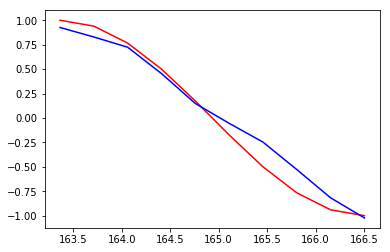

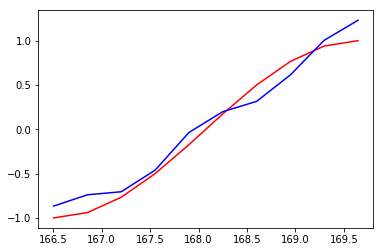

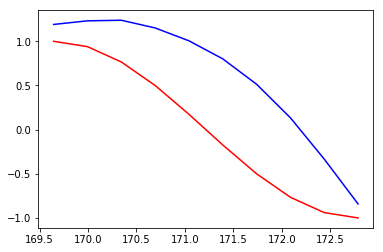

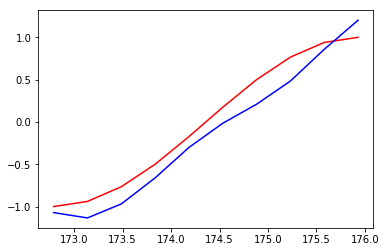

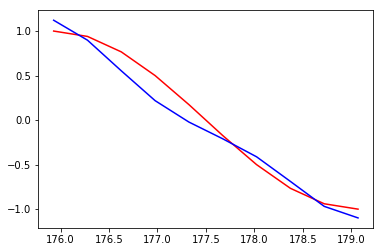

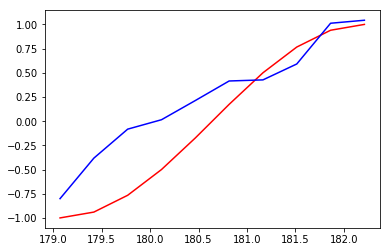

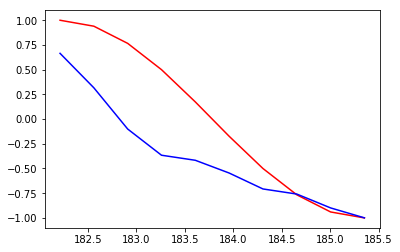

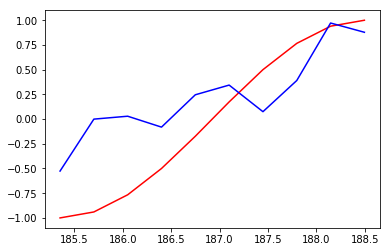

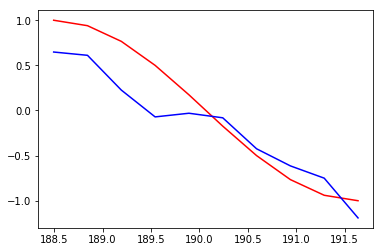

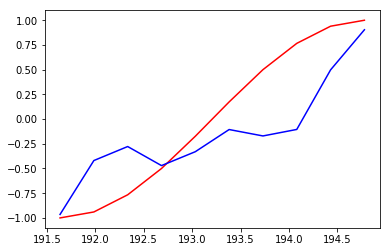

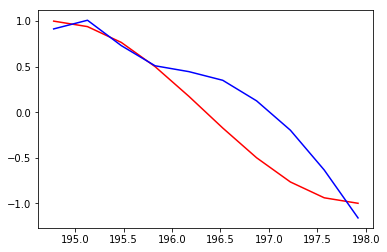

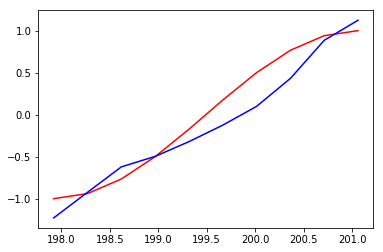

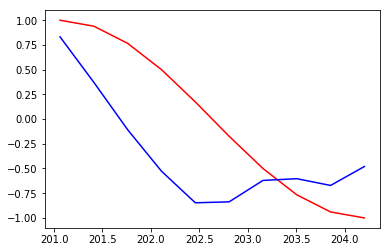

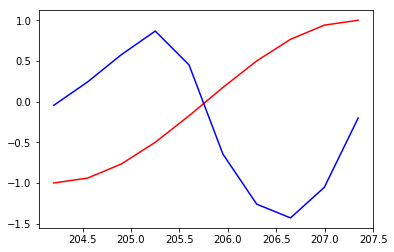

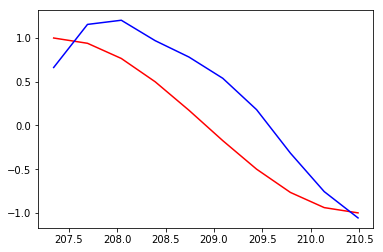

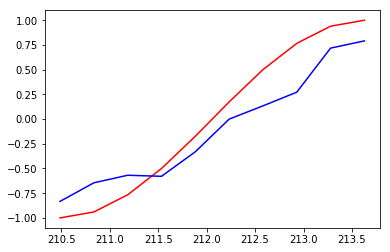

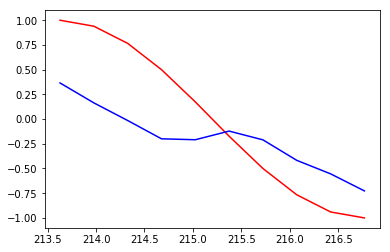

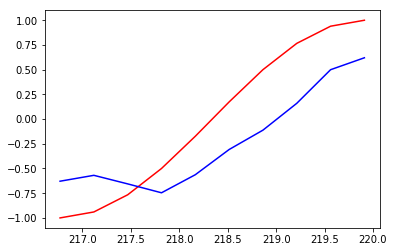

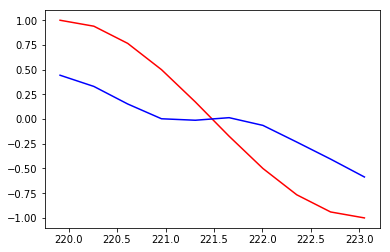

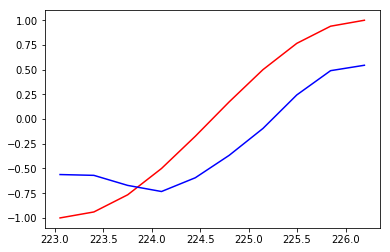

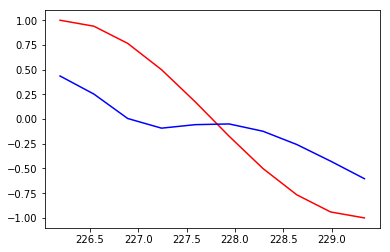

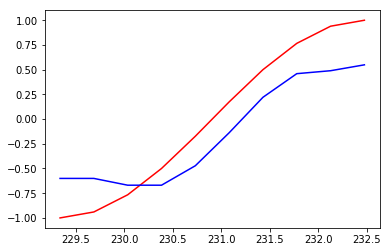

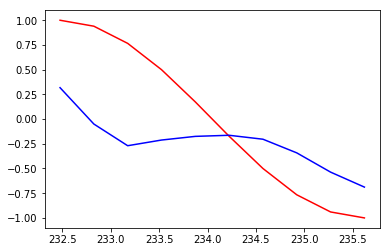

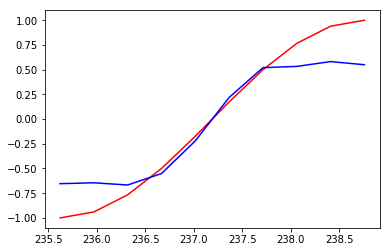

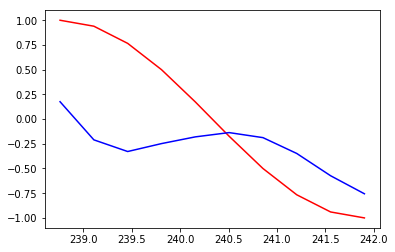

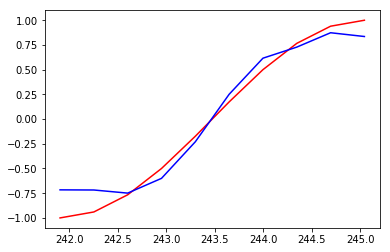

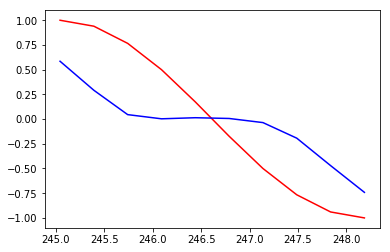

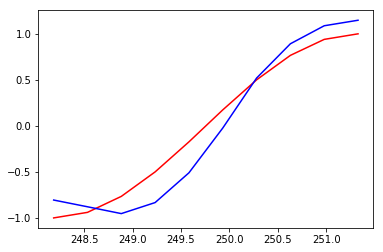

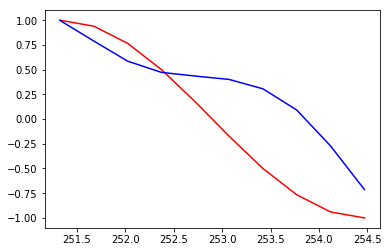

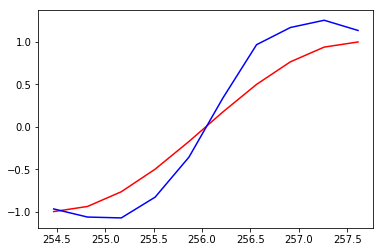

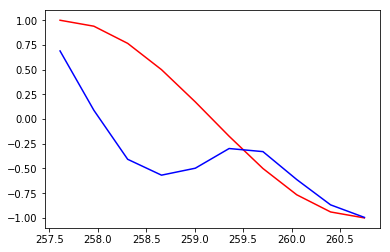

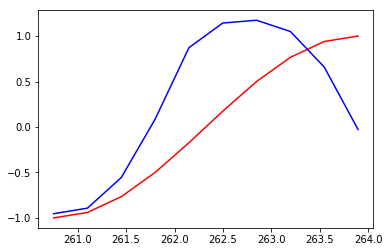

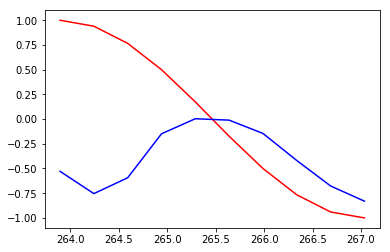

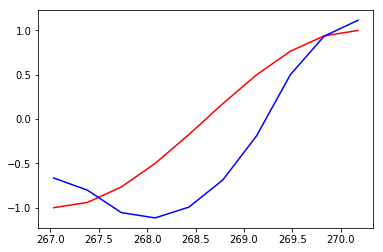

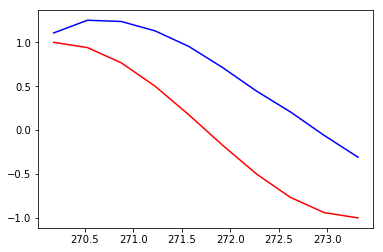

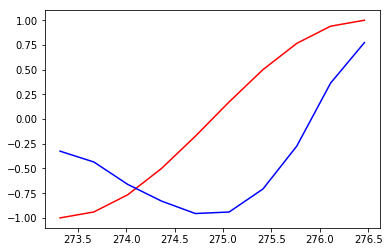

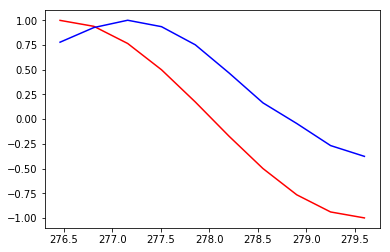

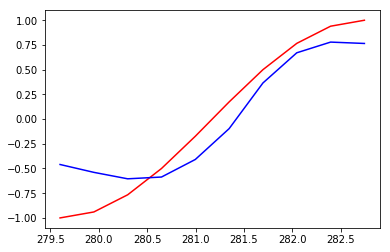

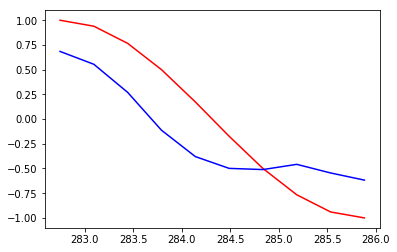

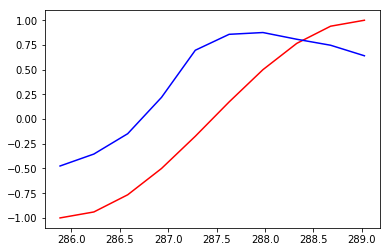

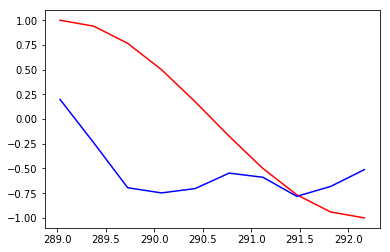

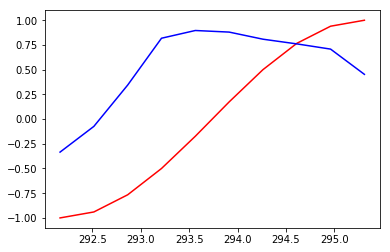

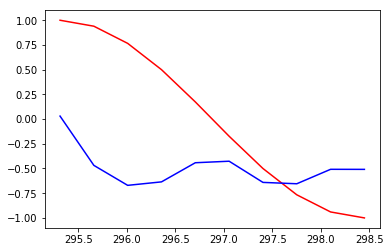

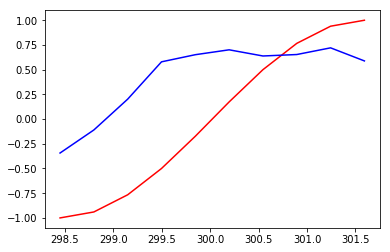

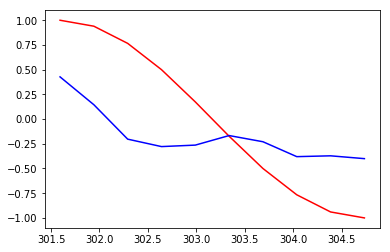

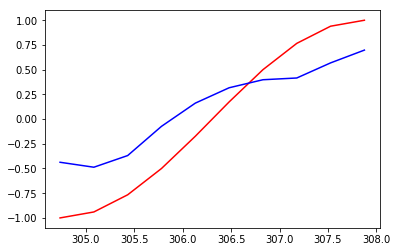

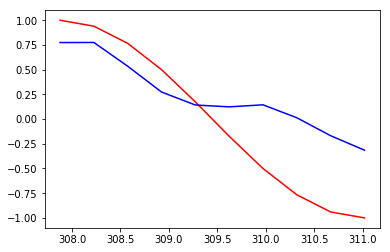

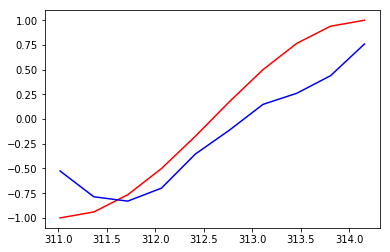

In [38]:
for step in range(100):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)  # float32 for converting torch FloatTensor
    x_np = np.sin(steps)
    y_np = np.cos(steps)

    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])    # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = h_state.data        # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # calculate loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)

plt.ioff()
plt.show()